In [ ]:
import os
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import ttest_rel


In [2]:
print('MNE–Python version', mne.__version__)
print('MNE–BIDS version', mne_bids.__version__)

MNE–Python version 1.9.0
MNE–BIDS version 0.16.0


### define inputs

In [146]:
'''# on Mac Studio Sharepoint
bids_root = os.path.join('/Users/dsj3886/',
                         'Library/CloudStorage/',
                         'OneDrive-NorthwesternUniversity',
                         'Documents - SoundBrain Lab',
                         'Lab Research Projects/',
                         'Experiments/NU_Experiments/',
                         'EAM1/', 'data-bids')
'''
# on MBA local (copied from Sharepoint)
bids_root = os.path.join('/Users/dsj3886/data_local/',
                        'EAM1_local/data-bids')


In [ ]:
# outputs
deriv_dir = os.path.join(bids_root, 'derivatives')

# Combine multiple runs (BIDS)

In [5]:
task_list = ['active', 'passive']

In [ ]:
for sub_num in range(2, 35):
    sub_label = f'{sub_num:02d}'

    # initialize an empty dictionary for data
    task_evoked_dict = {}
    event_evoked_dict = {}

    for task_label in task_list:
        print(f'Loading {task_label} data')

        epoch_list = []

        for run_label in range(1,6):
        # load in EEG data
            bids_path = BIDSPath(root=bids_root, datatype='eeg', 
                                 subject=str(sub_label), 
                                 task=task_label, 
                                 run=run_label)
            
            try:
                data = read_raw_bids(bids_path)
                data.load_data()

                # re-reference data to linked mastoid reference
                data_ref = data.set_eeg_reference(ref_channels=['M1', 'M2'])
                
                # filter data
                data_filtered = data_ref.copy().filter(l_freq=65, h_freq=2000)

                # loading events from the stim-track-generated events
                events_fpath = sorted(glob(os.path.join(deriv_dir, 'events-stimtrack') + 
                        f'/*{sub_label}*{task_label}*{run_label}_stimtrack_events.tsv'))[0]
                events_df = pd.read_csv(events_fpath, delimiter='\t') 
                annot = mne.Annotations(onset=events_df.onset, duration=0.170, description=events_df.type)
                data_filtered.set_annotations(annot)
                events_from_annot, event_dict2 = mne.events_from_annotations(data_filtered)
                
                # epoch data based on stimulus events
                epochs = mne.Epochs(data_filtered, 
                                    events=events_from_annot, 
                                    event_id=event_dict2,
                                    on_missing='warn',
                                    picks=['Cz'],
                                    tmin=-0.04, tmax=0.4, 
                                    baseline=[-0.04, 0],
                                    reject=dict(eeg=75e-6)).drop_bad()
                
                epoch_list.append(epochs)

            except:
                print(f"No run {run_label} for task-{task_label}")
        
        try:
            # combine epochs across runs
            all_epochs = mne.concatenate_epochs(epoch_list)
        except IndexError:
            print(f'cannot run for sub-{sub_label} task-{task_label} run-{run_label}')

        try:
            out_base = f'sub-{sub_label}_task-{task_label}_run-all_event-stimtrack_epochs.fif'
            all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
        except:
            continue


# Combine participants

In [151]:
# check outputs
sorted(glob(deriv_dir+'/*run-all_event-stimtrack_epochs.fif'))[:8]

['/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-02_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-03_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-04_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/sub-05_task-passive_run-all_event-stimtrack_epochs.fif']

In [ ]:
act_pos_avgs = []
act_neg_avgs = []
act_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-active_run-all_event-stimtrack_epochs.fif') 
                  for sub_num in range(2,35))]
for act_ep in act_eps[0]:
    try:
        sub_active_epochs = mne.read_epochs(act_ep[0])
        act_pos_avgs.append(sub_active_epochs['1'].average())
        act_neg_avgs.append(sub_active_epochs['2'].average())
    except:
        pass

pas_pos_avgs = []
pas_neg_avgs = []
pas_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-passive_run-all_event-stimtrack_epochs.fif') 
                  for sub_num in range(2,35))]
for pas_ep in pas_eps[0]:
    try:
        sub_passive_epochs = mne.read_epochs(pas_ep[0])
        pas_pos_avgs.append(sub_passive_epochs['1'].average())
        pas_neg_avgs.append(sub_passive_epochs['2'].average())
    except:
        pass


In [ ]:
# check the outputs
act_pos_avgs[:8]

[<Evoked | '1' (average, N=1165), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1776), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1796), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1785), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1744), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1124), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1072), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1767), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>]

In [ ]:
# create grand averages per polarity per condition
pas_pos_grandavg = mne.grand_average(pas_pos_avgs)
pas_neg_grandavg = mne.grand_average(pas_neg_avgs)
act_pos_grandavg = mne.grand_average(act_pos_avgs)
act_neg_grandavg = mne.grand_average(act_neg_avgs)

# create grand averages per condition
passive_grandavg = mne.grand_average(pas_pos_avgs+pas_neg_avgs)
active_grandavg = mne.grand_average(act_pos_avgs+act_neg_avgs)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


## Combined polarities

In [134]:
evokeds = dict(passive=passive_grandavg, active=active_grandavg)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_83030/2310340775.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds,


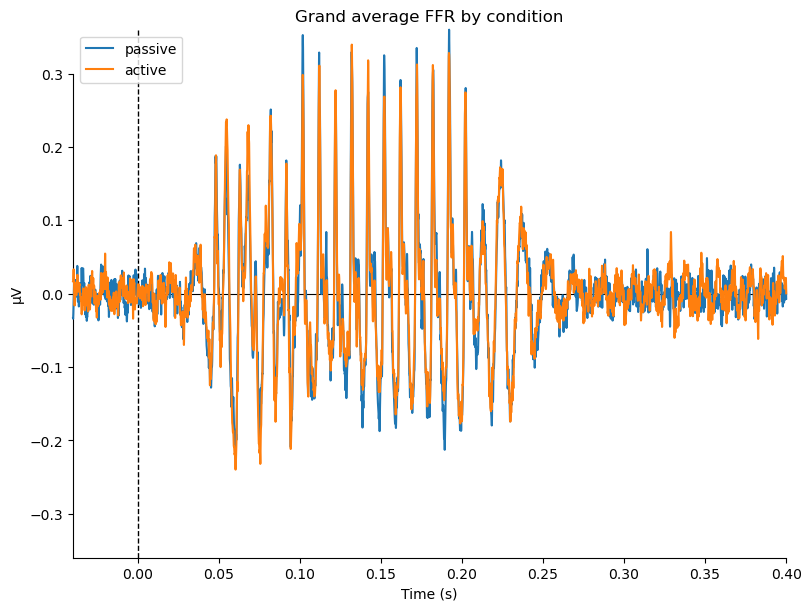

[<Figure size 800x600 with 1 Axes>]

In [154]:
mne.viz.plot_compare_evokeds(evokeds, 
                             title='Grand average FFR by condition',
                             truncate_xaxis=False)

Effective window size : 0.100 (s)
Effective window size : 0.100 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


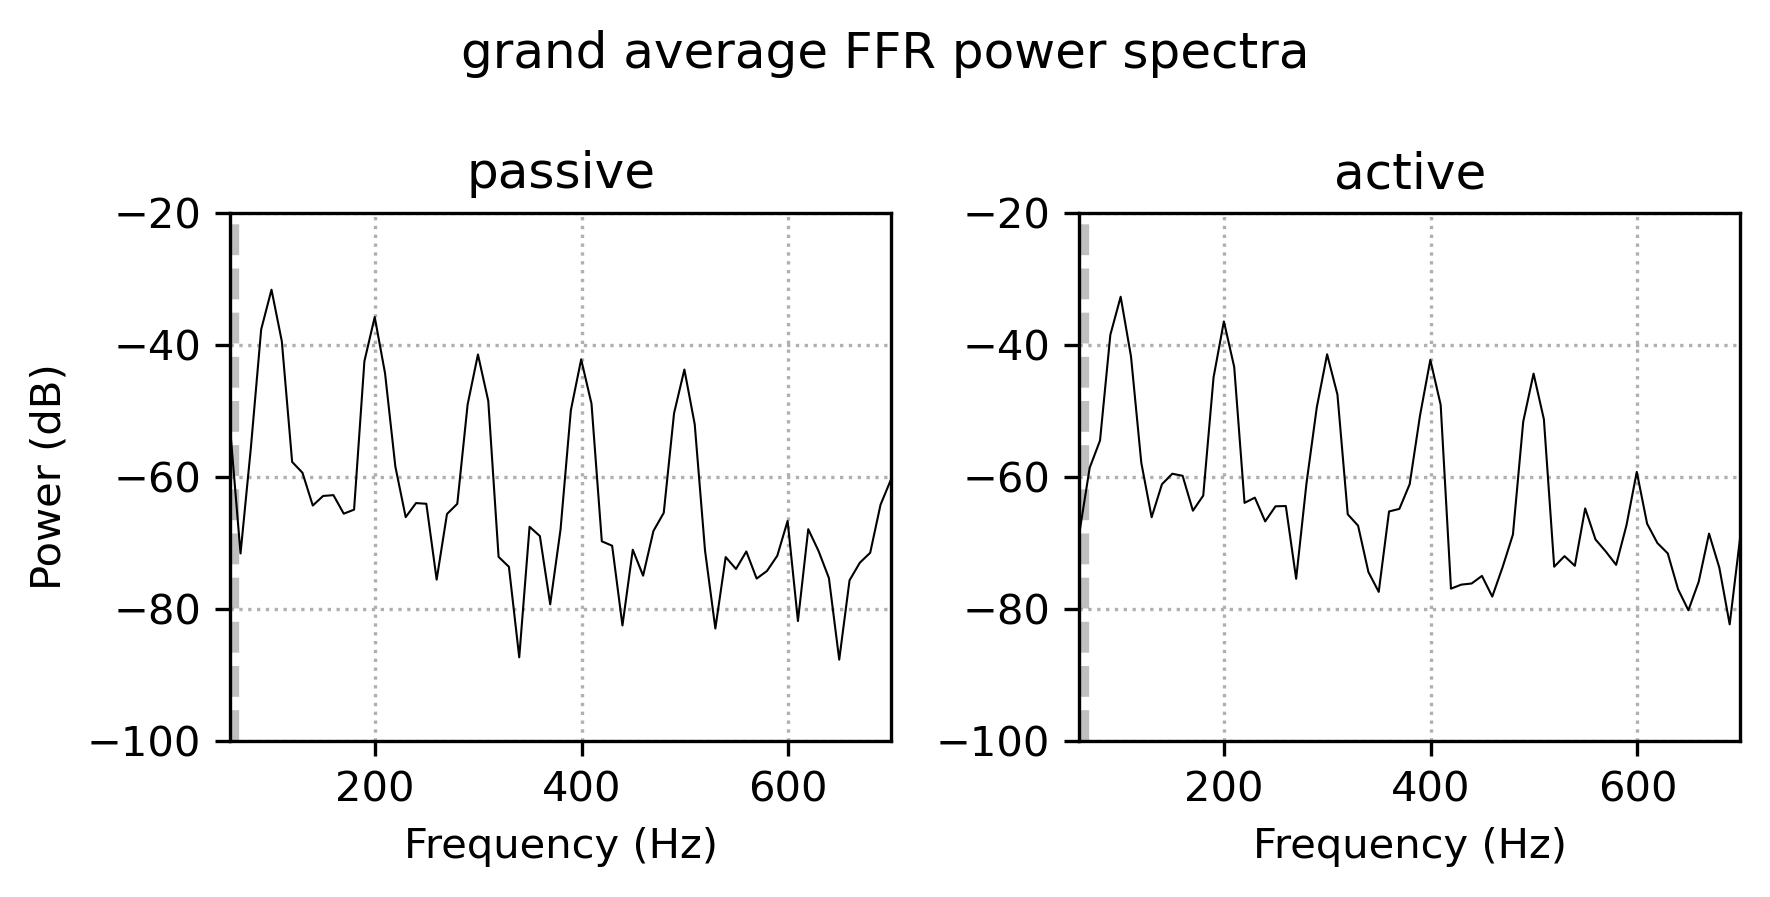

In [161]:
# Power spectra
passive_psd = passive_grandavg.compute_psd(method='welch',
                                           tmin=0.1, tmax=0.2, fmin=50, fmax=700)
active_psd = active_grandavg.compute_psd(method='welch',
                                           tmin=0.1, tmax=0.2, fmin=50, fmax=700)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=300)
ax = axes.flatten()
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
#active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_ylim([-100, -20])
ax[1].set_ylim([-100, -20])

ax[0].set_title('passive')
ax[1].set_title('active')

ax[0].set_ylabel('Power (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied


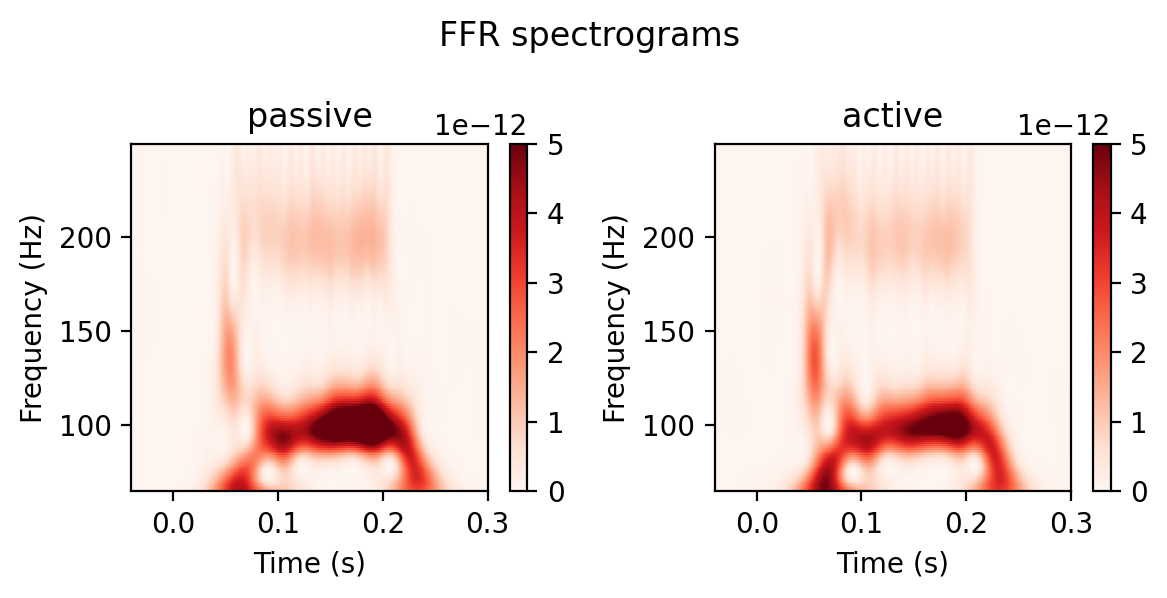

In [ ]:
# Spectrograms
frequencies = np.arange(65,250)

passive_power = passive_grandavg.compute_tfr("morlet", freqs=frequencies)
active_power = active_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
active_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_spectrograms.svg')

No baseline correction applied
No baseline correction applied


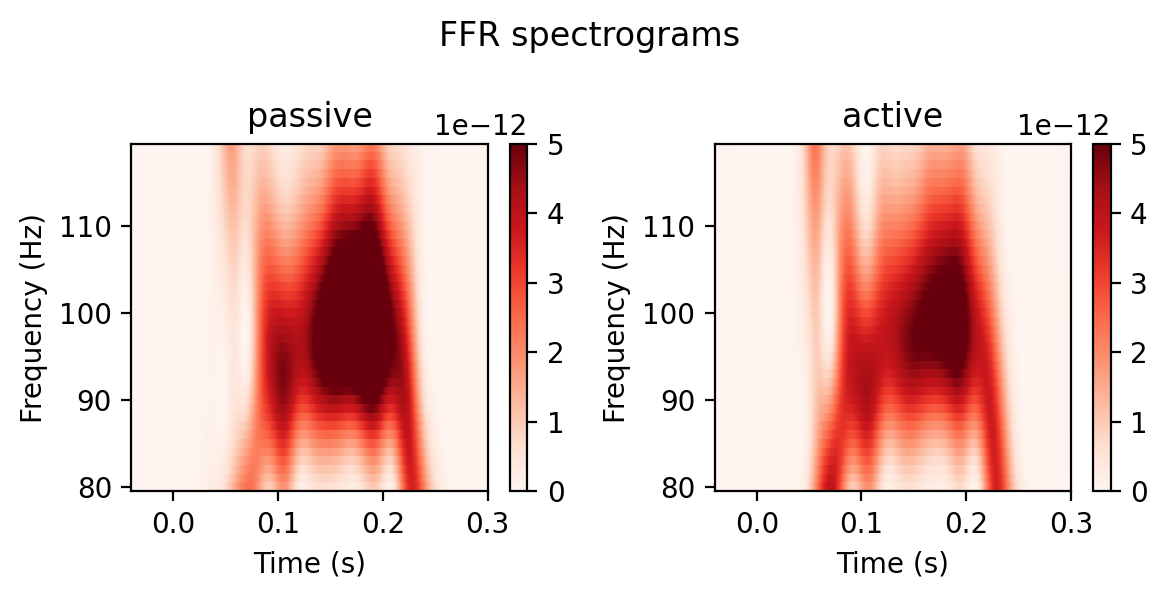

In [ ]:
# Spectrograms – smaller frequency range
frequencies = np.arange(80,120)

passive_power = passive_grandavg.compute_tfr("morlet", freqs=frequencies)
active_power = active_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
active_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_freq-80-120_spectrograms.svg')

### Power stats

In [65]:
def compute_power(avg_evoked, f_low=90, f_high=110, t_low=0.1, t_high=0.2):
    # Compute the spectrogram (time-frequency representation)
    power = mne.time_frequency.tfr_multitaper(avg_evoked, 
                                            freqs=np.arange(f_low, f_high, 1), 
                                            n_cycles=2, time_bandwidth=4.0,
                                            average=True, return_itc=False)

    # Select the time and frequency bands
    time_mask = (power.times >= t_low) & (power.times <= t_high)
    freq_mask = (power.freqs >= f_low) & (power.freqs <= f_high)

    # Extract the power within the specified bands
    selected_power = power.data[:, freq_mask, :][:, :, time_mask]

    # Average power over the selected time and frequency bands
    average_power = selected_power.mean(axis=2).mean(axis=1)[0]
    return average_power

In [ ]:
# Extract power for passive condition
pas_power_list = []
for evk in pas_pos_avgs+pas_neg_avgs:
    power = compute_power(evk)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in act_pos_avgs+act_neg_avgs:
    power = compute_power(evk)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

In [129]:
# check the power dataframe
power_df.head()

,passive,active
0,2.113767e-12,3.488621e-12
1,1.012587e-12,6.006882e-13
2,1.347938e-11,1.521170e-11
3,1.322315e-12,1.623769e-12
4,1.719667e-11,2.110612e-11


In [ ]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive power: 7.370905532304652e-12
Mean active power: 1.1000127891718609e-11
power t-statistic: -1.468, p-value: 0.147


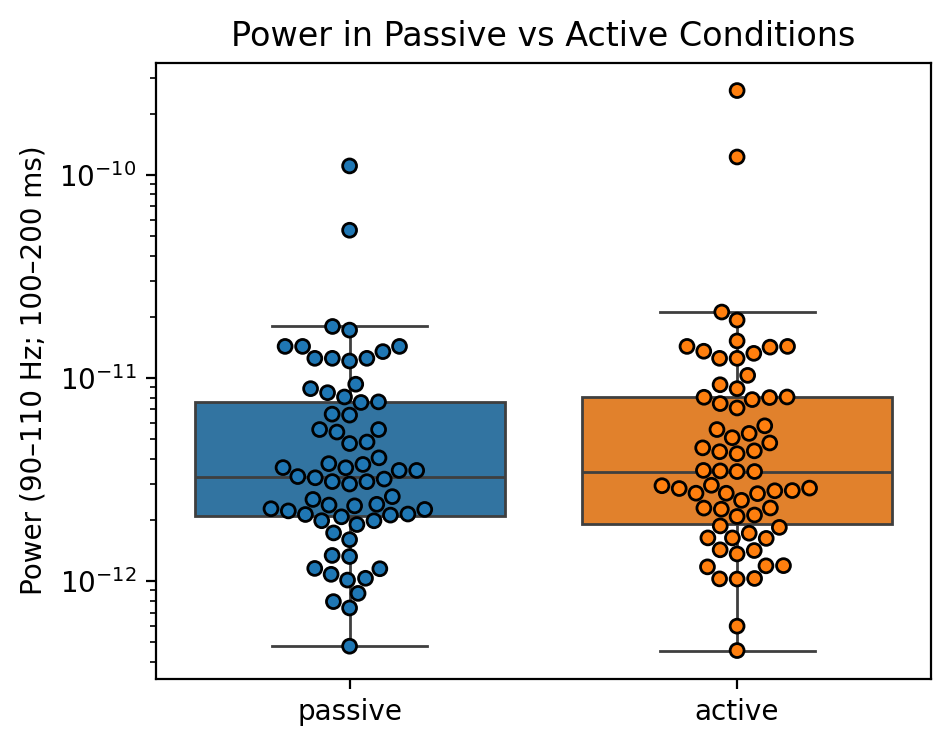

In [111]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel('Power (90–110 Hz; 100–200 ms)')
plt.title('Power in Passive vs Active Conditions')
plt.show()

### RMS SNR stats

In [ ]:
from numpy import mean, sqrt, square

In [ ]:
# helper function to compute RMS SNR
def compute_rms(evoked):
    baseline_ind_bounds = evoked.time_as_index(evoked.baseline)
    response_ind_bounds = evoked.time_as_index([0.100, 0.200])

    evoked_baseline = evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline
    return rms_snr

In [ ]:
# compute RMS SNR for each condition for the grand average
task_evoked_dict = {}
task_evoked_dict['passive'] = passive_grandavg
task_evoked_dict['active']  = active_grandavg

for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    rms_snr = compute_rms(s_evoked)

    print(f'{stim} RMS SNR: {rms_snr:.04f}')


passive RMS SNR: 8.1159
active RMS SNR: 8.3971


In [ ]:
# compute RMS SNR for each condition
pas_rms_list = []
for evk in pas_pos_avgs+pas_neg_avgs:
    rms_snr = compute_rms(evk)
    pas_rms_list.append(rms_snr)

act_rms_list = []
for evk in act_pos_avgs+act_neg_avgs:
    rms_snr = compute_rms(evk)
    act_rms_list.append(rms_snr)

# Create a DataFrame for RMS SNR values
rms_dict = {'passive': pas_rms_list,  
              'active': act_rms_list}
rms_df = pd.DataFrame(rms_dict)


In [ ]:
# calculate mean RMS SNR for each condition
rms_pass_mean = rms_df['passive'].mean()
rms_act_mean = rms_df['active'].mean()
print(f'Mean passive RMS ratio: {rms_pass_mean:.03f}')
print(f'Mean active RMS ratio: {rms_act_mean:.03f}')

# Perform paired t-test
t_stat, p_value = ttest_rel(rms_dict['passive'], rms_dict['active'])
print(f"RMS ratio t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive RMS ratio: 2.734
Mean active RMS ratio: 2.713
RMS ratio t-statistic: 0.232, p-value: 0.817


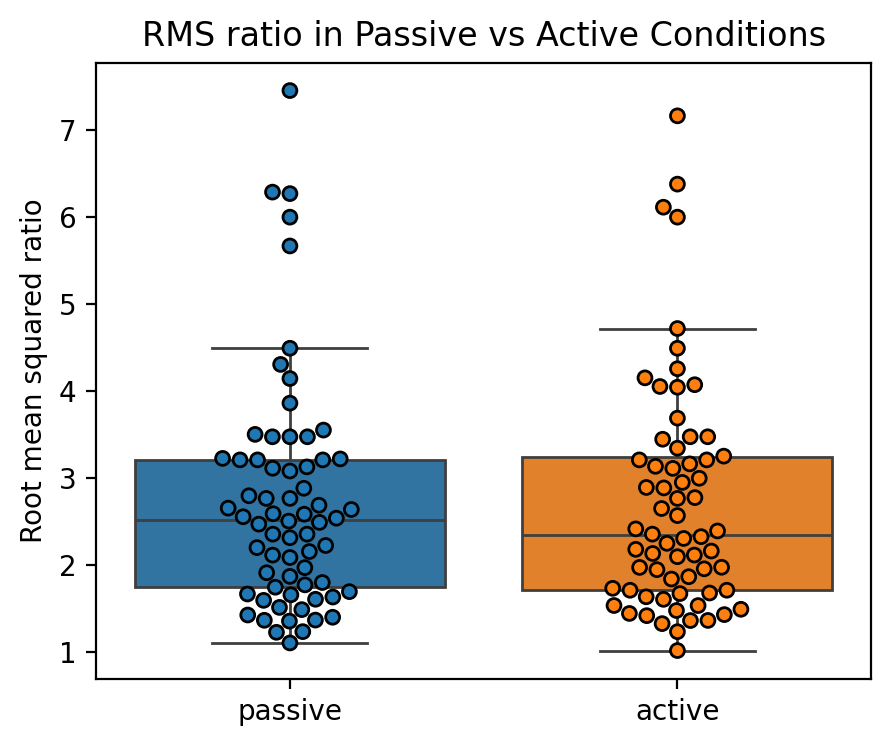

In [104]:
# Plotting the RMS values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(rms_df, edgecolor='k', linewidth=1)
sns.boxplot(rms_df, fliersize=0)
plt.ylabel('Root mean squared ratio')
plt.title('RMS ratio in Passive vs Active Conditions')
plt.show()

## Individual polarities

In [133]:
evokeds_polar = dict(passive_positive=pas_pos_avgs, 
                     passive_negative=pas_neg_avgs, 
                     active_positive=act_pos_avgs, 
                     active_negative=act_neg_avgs)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_83030/2459182516.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds_polar,


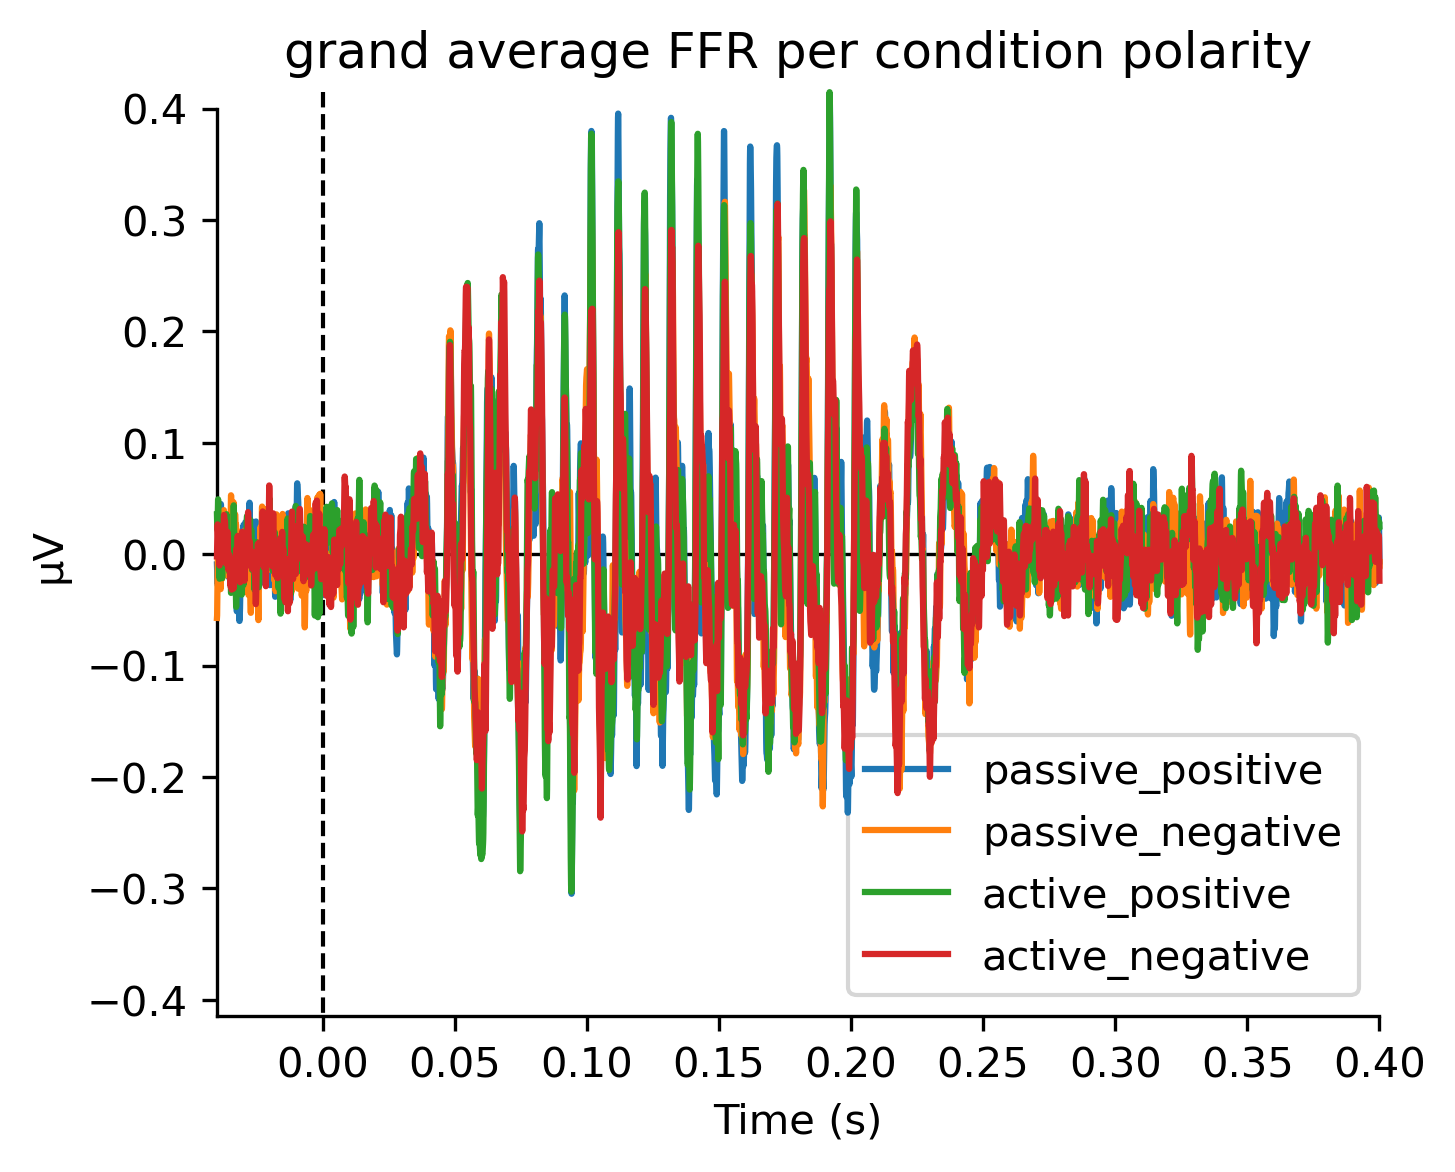

[<Figure size 1500x1200 with 1 Axes>]

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300)
mne.viz.plot_compare_evokeds(evokeds_polar, 
                             #[pas_pos_grandavg,pas_neg_grandavg,act_pos_grandavg, act_neg_grandavg],
                             ci=False,
                             truncate_xaxis=False,
                             legend='lower right',
                             title='grand average FFR per condition polarity',
                             axes=ax)

Text(0.5, 1.0, 'active/negative')

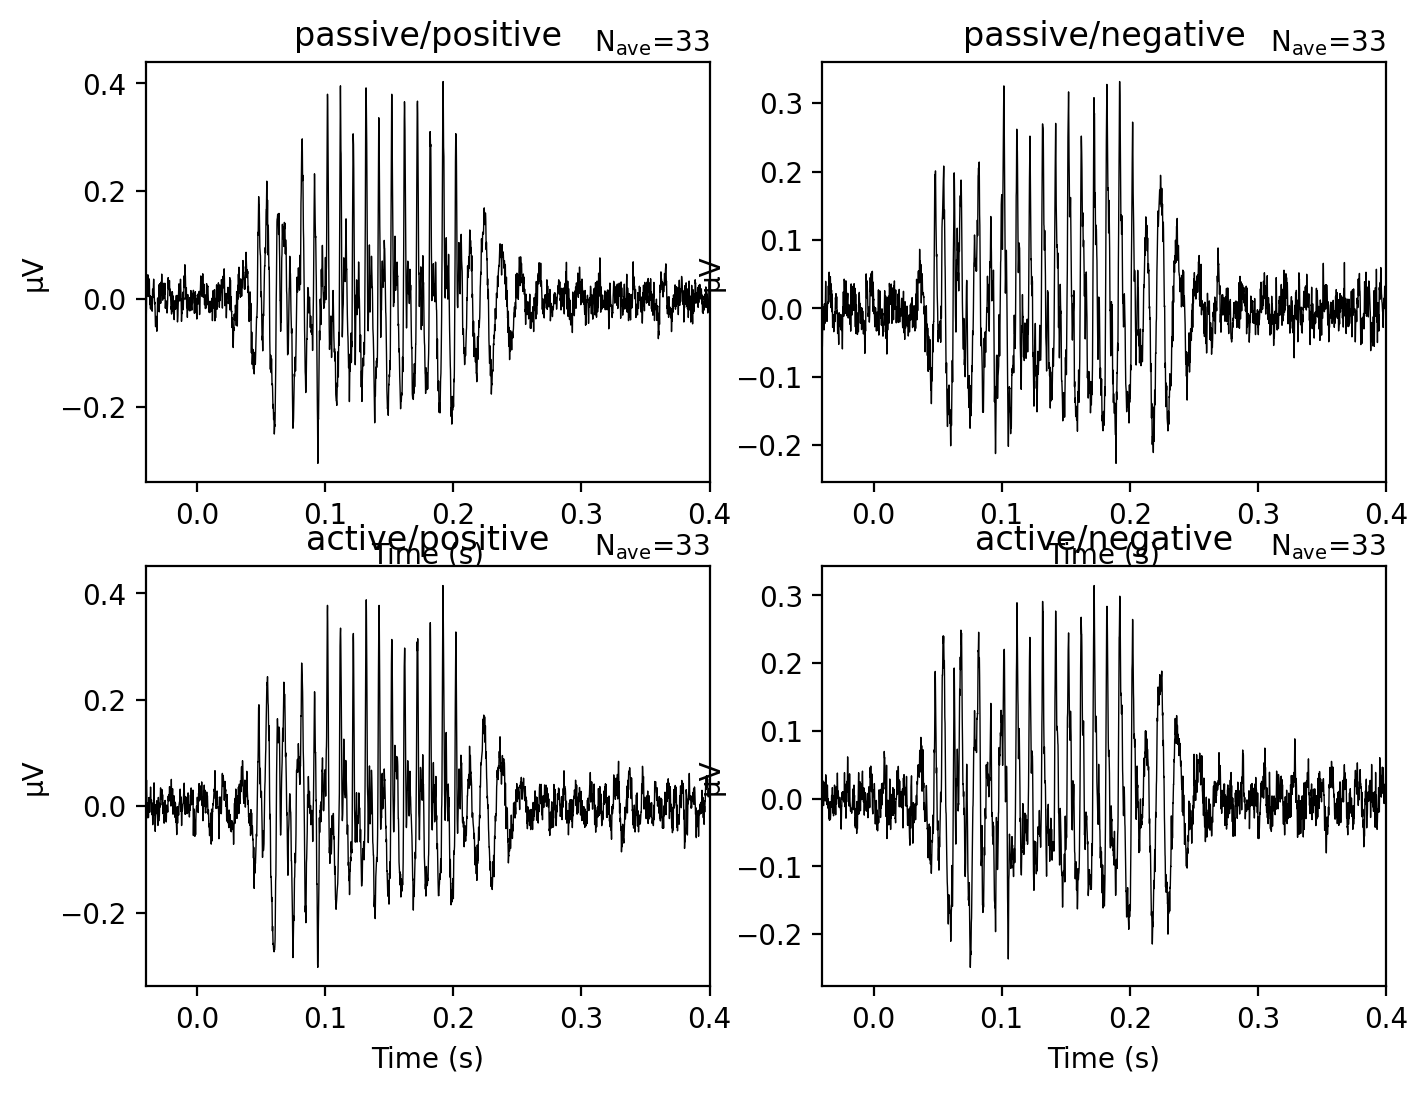

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
pas_pos_grandavg.plot(axes=ax[0], selectable=False, show=False)
pas_neg_grandavg.plot(axes=ax[1], selectable=False, show=False)
act_pos_grandavg.plot(axes=ax[2], selectable=False, show=False)
act_neg_grandavg.plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


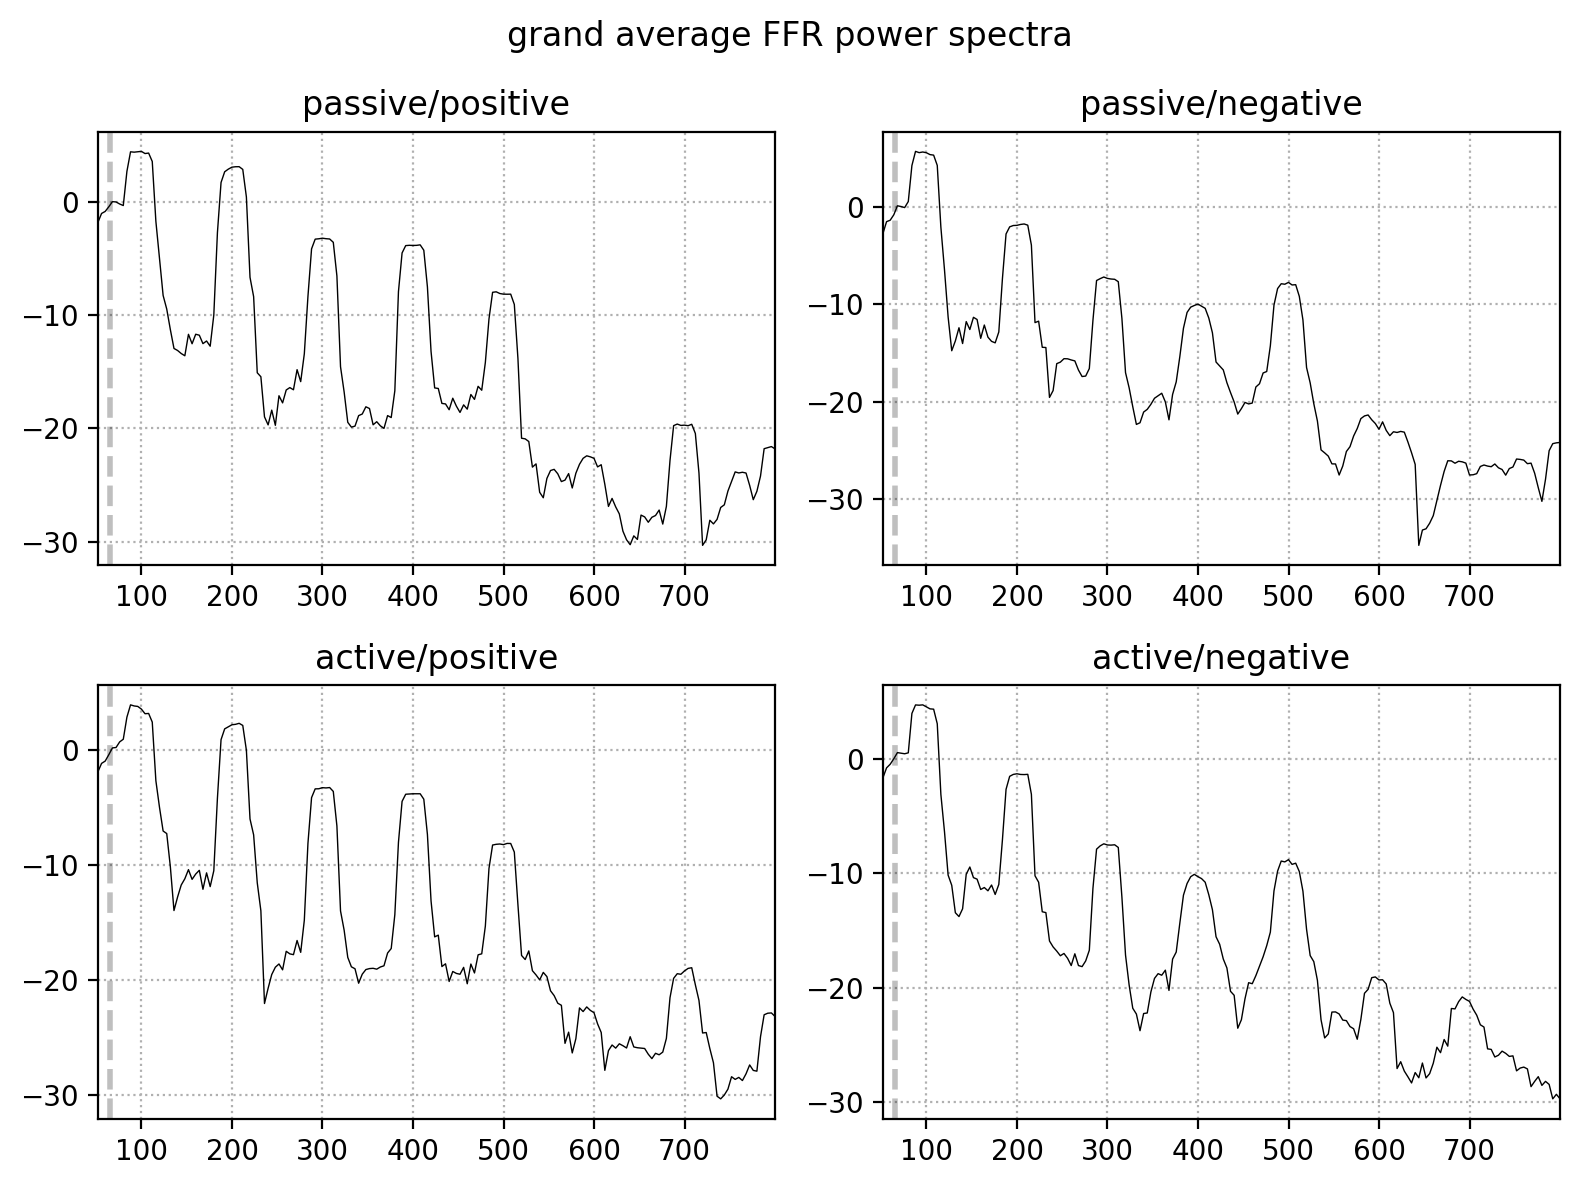

In [162]:
# Power spectra
passive_pos_psd = pas_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
passive_neg_psd = pas_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_pos_psd = act_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_neg_psd = act_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


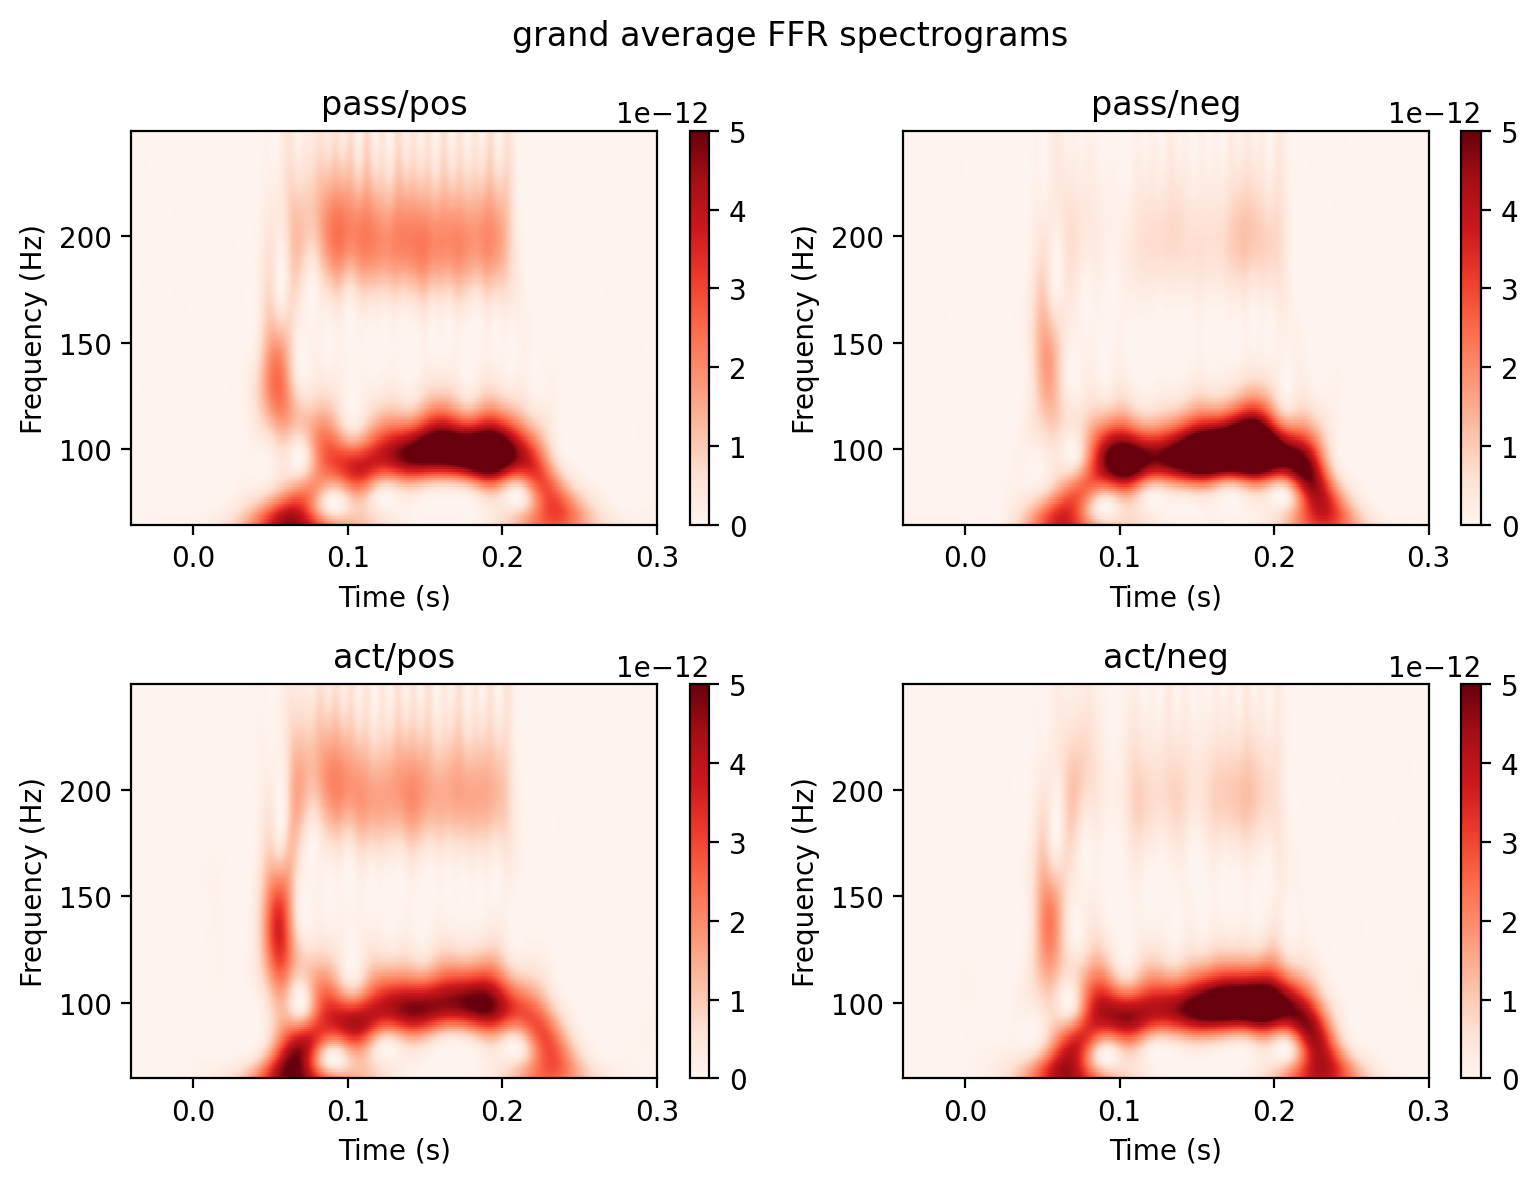

In [94]:
# Spectrograms
passive_pos_power = pas_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
passive_neg_power = pas_neg_grandavg.compute_tfr("morlet", freqs=frequencies)
active_pos_power  = act_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
active_neg_power  = act_neg_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
passive_neg_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)
active_pos_power.plot(axes=ax[2], tmax=0.3, vlim=[0, 5e-12], show=False)
active_neg_power.plot(axes=ax[3], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

# [IN PREP] QA and metrics

## [IN PREP] Autocorrelation

In [ ]:
import statsmodels.api as sm

In [43]:
acf, confint = sm.tsa.stattools.acf(all_evoked.data[0,:], 
                                    nlags=len(all_evoked.data[0,:])-1,
                                    alpha=.05)

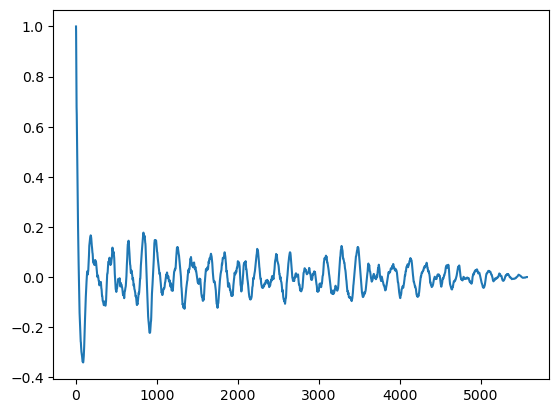

In [44]:
plt.plot(acf)
plt.show()

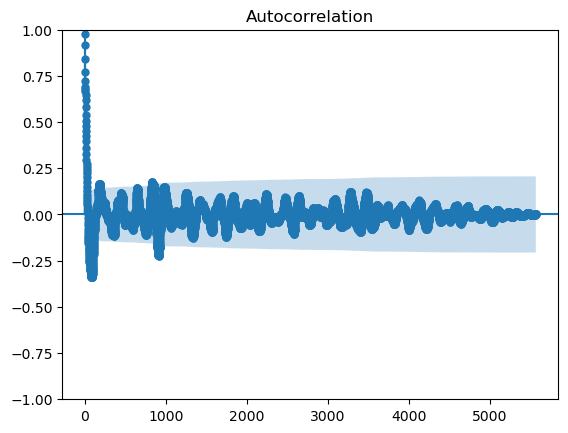

In [45]:
sm.graphics.tsa.plot_acf(all_evoked.data[0,:], 
                         lags=len(all_evoked.data[0,:])-1, 
                         zero=False,)

## [IN PREP] Stimulus–response correlations


In [46]:
data.pick(['Erg1'])

Measurement date,"July 18, 2024 13:12:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,Not available
Good channels,1 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,16384.00 Hz
Highpass,0.00 Hz
Lowpass,3334.00 Hz


In [47]:
# epoch data based on stimulus events
stim_epochs = mne.Epochs(data_filtered, 
                    events, 
                    event_id=event_dict,
                    picks=['Erg1'],
                    tmin=-0.04, tmax=0.3, 
                    baseline=[-0.04, 0],
                    #reject = dict(eeg = 35e-6)).drop_bad()
                    reject=dict(eeg=75)).drop_bad()

Not setting metadata
1170 matching events found
Setting baseline interval to [-0.04, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1170 events and 5571 original time points ...
0 bad epochs dropped


In [48]:
stim_epochs

Number of events,1170
Events,button_press: 1170
Time range,-0.040 – 0.300 s
Baseline,-0.040 – 0.000 s


In [49]:
stim_epochs.average()

Condition,button_press
Data kind,average
Timepoints,5571 samples
Channels,1 channels
Number of averaged epochs,1170
Time range (secs),-0.03997802734375 – 0.29998779296875
Baseline (secs),-0.040 – 0.000 s


Need more than one channel to make topography for eeg. Disabling interactivity.


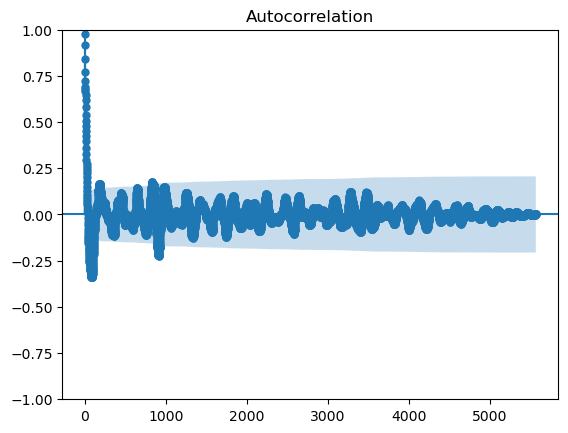

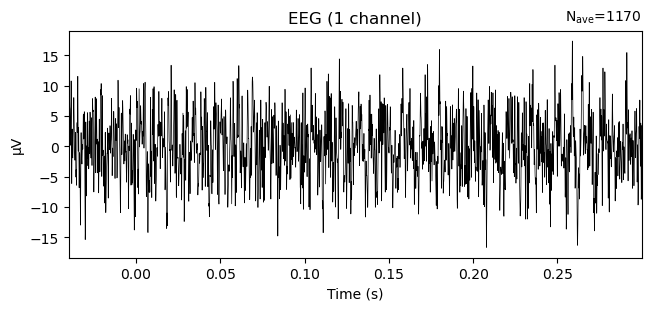

In [50]:
stim_epochs.average().plot();

In [51]:
stim_data = stim_epochs.average().get_data()[0,:]
active_data = task_evoked_dict['active'].get_data()[0,:]
passive_data = task_evoked_dict['passive'].get_data()[0,:]

In [78]:
np.array(range(len(stim_data)))

array([   0,    1,    2, ..., 5568, 5569, 5570])

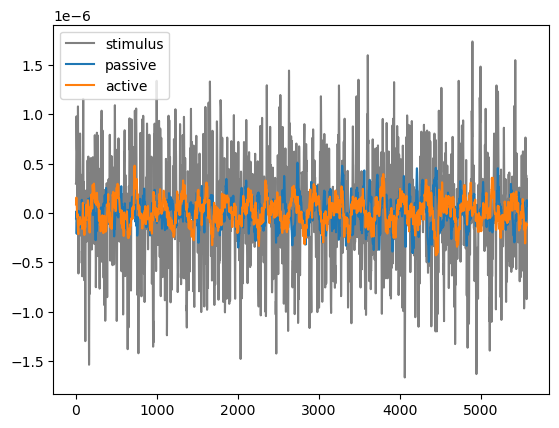

In [86]:
plt.plot(stim_data/10, color='grey')
plt.plot(passive_data)
plt.plot(active_data)
plt.legend(['stimulus','passive','active'])
#plt.xaxis(np.array(range(len(stim_data)))/16384)
plt.show()

In [52]:
from scipy.stats import spearmanr
active_res = spearmanr(active_data, stim_data, alternative='greater')
passive_res = spearmanr(passive_data, stim_data, alternative='greater')


In [53]:
active_res

SignificanceResult(statistic=0.013488523482214512, pvalue=0.15706554806619186)

In [54]:
passive_res

SignificanceResult(statistic=-0.0022353155565718644, pvalue=0.5662381718955769)